In [57]:
import pandas as pd
from ord_data_load import ORD_PATH, is_reaction_of_type, df_na_vals
from chem_render import draw_reaction, indigo
from rdkit.Chem.rdChemReactions import ReactionFromSmarts

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
ProgressBar().register()

#to disable warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%%time
all_reactions = pd.read_pickle(f"{ORD_PATH}/all_reactions.pkl")

CPU times: total: 19.8 s
Wall time: 19.7 s


In [8]:
%%time
uspto_df = all_reactions.loc[~all_reactions['patent'].isna()]
uspto_df.shape

CPU times: total: 453 ms
Wall time: 459 ms


(1771032, 12)

In [62]:
df_na_vals(uspto_df)

reaction_smile        ->         Missing values: 0 (0.00%)
solvents              ->         Missing values: 404688 (22.85%)
reactants             ->         Missing values: 0 (0.00%)
catalysts             ->         Missing values: 1521387 (85.90%)
reagents              ->         Missing values: 1771032 (100.00%)
temperature           ->         Missing values: 685982 (38.73%)
time                  ->         Missing values: 896508 (50.62%)
product               ->         Missing values: 40191 (2.27%)
yield                 ->         Missing values: 810935 (45.79%)
notes                 ->         Missing values: 0 (0.00%)
patent                ->         Missing values: 0 (0.00%)
original_dataset      ->         Missing values: 0 (0.00%)


['reagents']

## Compare Suzuki substructure searches for USPTO database

In [12]:
SUZUKI_PATTERN = "[B;X3,4]-[C,c:1].[C,c:2]-[Cl,Br,I,O]>>[C,c:1]-[C,c:2]"

In [16]:
# rdkit substructure search
dds = dd.from_pandas(uspto_df['reaction_smile'], npartitions=240)
suzuki_rdkit = dds.apply(is_reaction_of_type,
                 reaction_type_pattern=ReactionFromSmarts(SUZUKI_PATTERN),
                 meta=pd.Series(dtype=bool)).compute(scheduler='processes') # rdkit functions are not parallelizable using "threads"
suzuki_rdkit.sum()

[########################################] | 100% Completed | 85.08 s
[########################################] | 100% Completed | 85.19 s


44412

In [17]:
# indigo substructure search

query = indigo.loadReactionSmarts(SUZUKI_PATTERN)
query.optimize()

def rxn_match(rxn_smiles) -> bool:
    if rxn_smiles is None:
        return False
    return True if indigo.substructureMatcher(indigo.loadReaction(rxn_smiles)).match(query) else False

dds = dd.from_pandas(all_reactions['reaction_smile'], npartitions=240)
suzuki_indigo = dds.apply(rxn_match,
                 # args=[query,),
                 # rxn_query=query,
                 meta=pd.Series(dtype=bool)).compute(scheduler='threads')
suzuki_indigo.sum()

[########################################] | 100% Completed | 247.98 s
[########################################] | 100% Completed | 248.07 s


55759

In [18]:
print("{indigo}          : ", suzuki_indigo.sum())
print("{rdkit}           : ", suzuki_rdkit.sum())
print("{indigo} - {rdkit}: ", (suzuki_indigo & ~suzuki_rdkit).sum())
print("{rdkit} - {indigo}: ", (suzuki_rdkit & ~suzuki_indigo).sum())
print("{rdkit} ∪ {indigo}: ", (suzuki_rdkit | suzuki_indigo).sum())
print("{rdkit} ∩ {indigo}: ", (suzuki_rdkit & suzuki_indigo).sum())

{indigo}          :  55759
{rdkit}           :  44412
{indigo} - {rdkit}:  12910
{rdkit} - {indigo}:  6446
{rdkit} ∪ {indigo}:  57322
{rdkit} ∩ {indigo}:  37966


In [31]:
unique_rdkit = uspto_df[suzuki_rdkit & ~suzuki_indigo]

C:\Users\ergot\AppData\Local\Temp\ipykernel_30388\726617349.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unique_rdkit = uspto_df[suzuki_rdkit & ~suzuki_indigo]


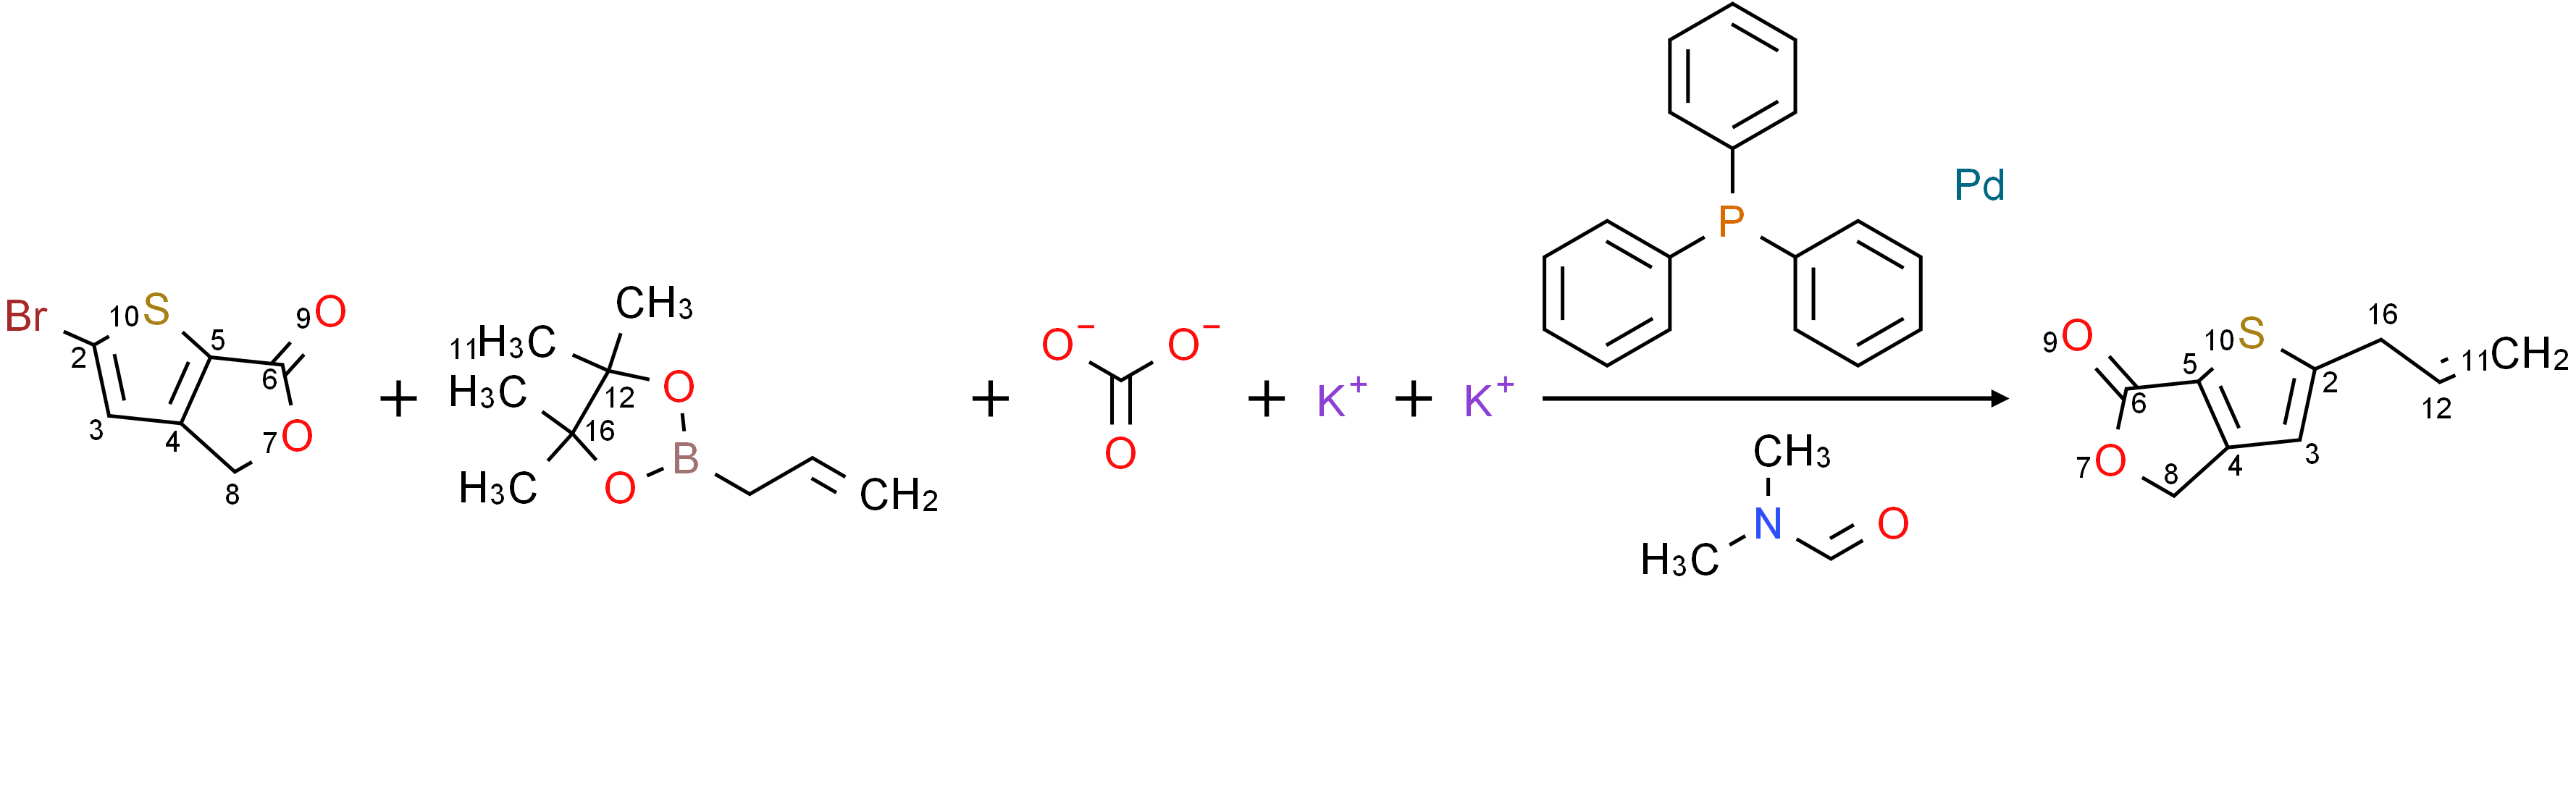

Patent:       US09056859B2
Reaction_id:  ord-1af1281819134703a6b23b055dda2752
In a 15 mL microwave reaction vial was added 2-bromothieno[2,3-c]furan-6(4H)-one (45 mg, 0.205 mmol), 4,4,5,5-tetramethyl-2-(prop-2-en-1-yl)-1,3,2-dioxaborolane (34.5 mg, 0.205 mmol, 1.0 eq), potassium carbonate (56.8 mg, 0.411 mmol, 2.0 eq) and palladium triphenylphosphane (1:4) (23.7 mg, 0.021 mmol, 0.1 eq). To above mixture was added DMF (1.0 mL), de-gas and filled with N2. The vial was heated to 100° C. for 60 min, cooled down, diluted with EtOAc, washed with aqueous sodium bicarbonate, brine and water. The organic phase was dried over anhydrous Na2SO4, filtered, concentrated. The crude product was purified by flash column chromatography. LC-MS (IE, m/z): 181.2 [M+1]+.
CPU times: total: 203 ms
Wall time: 218 ms


In [43]:
%%time
# unique to rdkit
draw_reaction(unique_rdkit)

In [44]:
unique_indigo = uspto_df[suzuki_indigo & ~suzuki_rdkit]

C:\Users\ergot\AppData\Local\Temp\ipykernel_30388\763254173.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unique_indigo = uspto_df[suzuki_indigo & ~suzuki_rdkit]


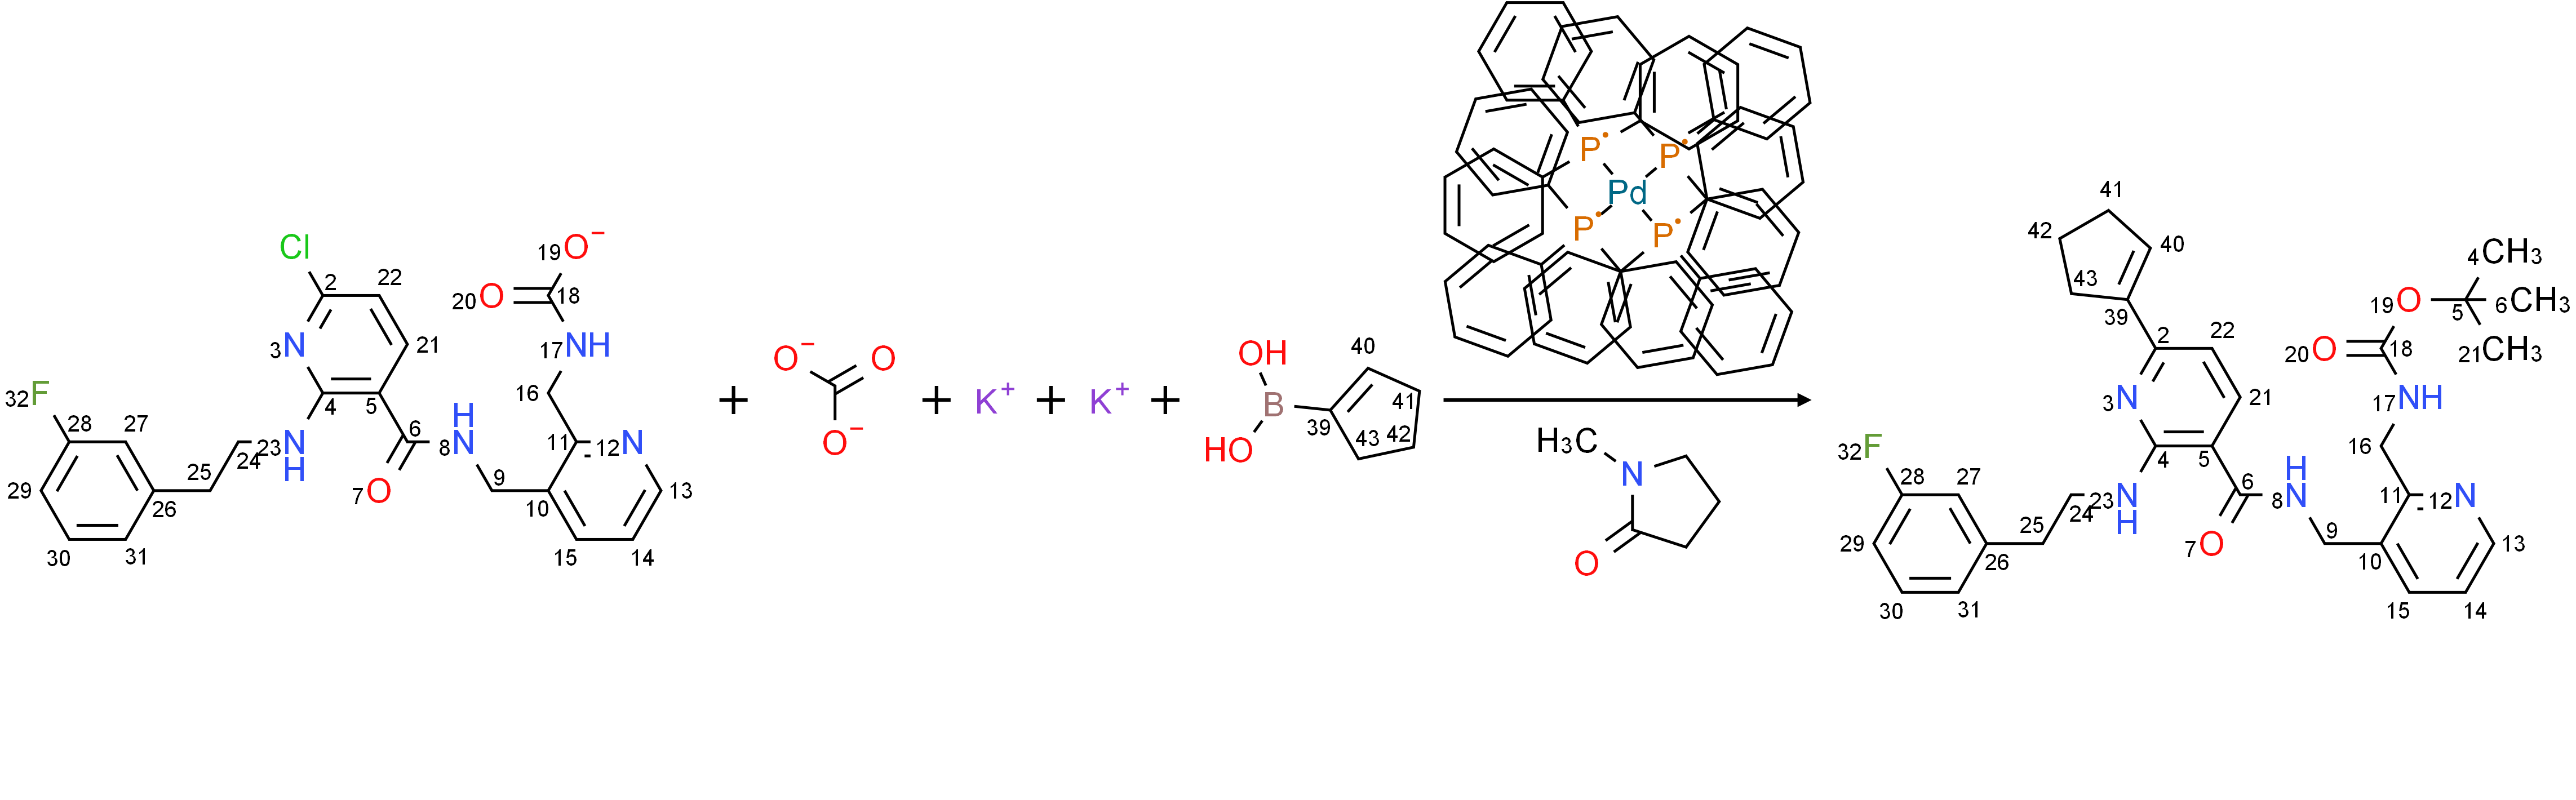

Patent:       US07939534B2
Reaction_id:  ord-e95cb7c2680642f6be3780019d75efaf
A mixture of (3-((6-chloro-2-(3-fluorophenethylamino)nicotinamido)methyl)pyridin-2-yl)methylcarbamate (0.10 g, 0.19 mmol), tetrakis(triphenylphosphine)palladium(0) (0.045 g, 0.039 mmol), K2CO3 (0.081 g, 0.59 mmol), cyclopenten-1-yl boronic acid (0.026 g, 0.23 mmol) and NMP (0.2 mL) was sealed in a tube and microwaved at 150° C. for 30 min. The reaction mixture was filtered through a silica plug with EtOAc, washed with H2O, brine, dried (Na2SO4) and concentrated to give tert-butyl (3-((6-cyclopentenyl-2-(3-fluorophenethylamino)nicotinamido)methyl)pyridin-2-yl)methylcarbamate. LC/MS (M+H+) m/z 546.2.


In [51]:
# unique to indigo
draw_reaction(unique_indigo)

In [19]:
# union of {rdkit} and {indigo} subsets
suzuki_df = uspto_df[suzuki_rdkit | suzuki_indigo]

C:\Users\ergot\AppData\Local\Temp\ipykernel_30388\1406287153.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  suzuki_df = uspto_df[suzuki_rdkit | suzuki_indigo]


In [59]:
%%time
suzuki_df.to_pickle(f"{ORD_PATH}/suzuki.pkl.zst")

CPU times: total: 922 ms
Wall time: 931 ms
